# NLP Relation Classification

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import numpy as np
import pickle
import tqdm
import nltk
import re
from io import open
from google.colab import files
import urllib.request
import os
import matplotlib.pyplot as plt
import math

from pdb import set_trace as bk

Any utility functions here

In [ ]:
def print_list(l, K=None):
	# If K is given then only print first K
	for i, e in enumerate(l):
		if i == K:
			break
		print(e)
	print()

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

print(f'GPU available: {torch.cuda.is_available()}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Wed May  5 12:02:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset Processing

In [ ]:
# Read in SemEval-2010 Task 8 Dataset
# https://github.com/sahitya0000/Relation-Classification
#urllib.request.urlretrieve('https://github.com/sahitya0000/Relation-Classification/blob/master/corpus/SemEval2010_task8_all_data.zip', 'SemEval2010_task8_all_data.zip')

!wget 'https://github.com/sahitya0000/Relation-Classification/raw/master/corpus/SemEval2010_task8_all_data.zip'


--2021-05-05 12:02:11--  https://github.com/sahitya0000/Relation-Classification/raw/master/corpus/SemEval2010_task8_all_data.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sahitya0000/Relation-Classification/master/corpus/SemEval2010_task8_all_data.zip [following]
--2021-05-05 12:02:11--  https://raw.githubusercontent.com/sahitya0000/Relation-Classification/master/corpus/SemEval2010_task8_all_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1964087 (1.9M) [application/zip]
Saving to: ‘SemEval2010_task8_all_data.zip’

SemEval2010_task8_a 100%[===================>]   1.87M  --.-KB

In [ ]:
!unzip 'SemEval2010_task8_all_data.zip'

Archive:  SemEval2010_task8_all_data.zip
   creating: SemEval2010_task8_all_data/
   creating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/answer_key1.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/answer_key2.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/answer_key3.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/answer_key5.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer1.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer2.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer3.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer4.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer5.txt  
  inflating: SemEval2010_task8

In [ ]:
#Pre-filtered GloVe embeddings
!wget https://raw.githubusercontent.com/aritter/aritter.github.io/master/files/glove.840B.300d.conll_filtered.txt

#Read GloVe embeddings.
def read_GloVe(filename):
  embeddings = {}
  for line in open(filename).readlines():
    #print(line)
    fields = line.strip().split(" ")
    word = fields[0]
    embeddings[word] = [float(x) for x in fields[1:]]
  return embeddings

GloVe = read_GloVe("glove.840B.300d.conll_filtered.txt")


--2021-05-04 19:26:58--  https://raw.githubusercontent.com/aritter/aritter.github.io/master/files/glove.840B.300d.conll_filtered.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69798443 (67M) [text/plain]
Saving to: ‘glove.840B.300d.conll_filtered.txt.4’

glove.840B.300d.con 100%[===================>]  66.56M   257MB/s    in 0.3s    

2021-05-04 19:26:59 (257 MB/s) - ‘glove.840B.300d.conll_filtered.txt.4’ saved [69798443/69798443]



Load raw sentences and labels from file

In [ ]:
def load_raw_from_file(file_name):
    with open(file_name, 'r') as file:
        lines = [line.strip() for line in file]

    sentences = []
    labels = []

    for index in range(0, len(lines), 4):
        sentence_num, sentence = lines[index].split('\t')
        label = lines[index+1]
        sentences.append(sentence)
        labels.append(label)

    return sentences, labels

In [ ]:
train_file = 'SemEval2010_task8_all_data/SemEval2010_task8_training/TRAIN_FILE.TXT'
test_file = 'SemEval2010_task8_all_data/SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT'

train_sentences, train_labels = load_raw_from_file(train_file)
test_sentences, test_labels = load_raw_from_file(test_file)

for sentence, label in zip(train_sentences[:10],  train_labels[:10]):
    print(sentence)
    print(label)
    print()

"The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>."
Component-Whole(e2,e1)

"The <e1>child</e1> was carefully wrapped and bound into the <e2>cradle</e2> by means of a cord."
Other

"The <e1>author</e1> of a keygen uses a <e2>disassembler</e2> to look at the raw assembly code."
Instrument-Agency(e2,e1)

"A misty <e1>ridge</e1> uprises from the <e2>surge</e2>."
Other

"The <e1>student</e1> <e2>association</e2> is the voice of the undergraduate student population of the State University of New York at Buffalo."
Member-Collection(e1,e2)

"This is the sprawling <e1>complex</e1> that is Peru's largest <e2>producer</e2> of silver."
Other

"The current view is that the chronic <e1>inflammation</e1> in the distal part of the stomach caused by Helicobacter pylori <e2>infection</e2> results in an increased acid production from the non-infected upper corpus region of the stomach."
Cause-Effect(e2,e1)

"<e1>People</e1> have

In [ ]:
word2i = {w:i+2 for i,w in enumerate(set([w for l in train_sentences for w in l] + list(GloVe.keys())))}

In [ ]:
pad_word = "<pad>"
bos_word = "<s>"
eos_word = "</s>"
unk_word = "<unk>"
e1_start_word = "<e1>"    # added for the attention model
e1_end_word = "</e1>"
e2_start_word = "<e2>"
e2_end_word = "</e2>"
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3
e1_start_id = 4     # added for the attention model
e1_end_id = 5
e2_start_id = 6
e2_end_id = 7

In [ ]:
'''
Raw input sample:

1	"The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>."
Component-Whole(e2,e1)
Comment: Not a collection: there is structure here, organisation.

'''
def normalize_sentence(s):
    s = re.sub(re.compile("|".join(re.escape(sym) for sym in ["<e1>", "</e1>", "<e2>", "</e2>"])), "", s)
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

def normalize_sentence_attn(s):
    s = re.sub("<e1>", "<e1> ", s)
    s = re.sub("<e2>", "<e2> ", s)
    s = re.sub("</e1>", " </e1>", s)
    s = re.sub("</e2>", " </e2>", s)
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?<>/1-2]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

class Vocabulary:
    def __init__(self, keep_entity_tag=True):
        if keep_entity_tag:
            self.word_to_id = {pad_word: pad_id, bos_word: bos_id, eos_word:eos_id, unk_word: unk_id, 
                            e1_start_word:e1_start_id, e1_end_word:e1_end_id, 
                            e2_start_word:e2_start_id, e2_end_word:e2_end_id}
        else:
            self.word_to_id = {pad_word: pad_id, bos_word: bos_id, eos_word:eos_id, unk_word: unk_id}

        self.word_count = {}
        # self.id_to_word = {pad_id: pad_word, bos_id: bos_word, eos_id: eos_word, unk_id: unk_word}
        self.id_to_word = {pair[1]: pair[0]  for pair in self.word_to_id.items()}
        self.num_words = len(self.word_to_id)

        self.keep_entity_tag = keep_entity_tag

    def get_ids_from_sentence(self, sentence):
        sentence = normalize_sentence_attn(sentence) if self.keep_entity_tag else normalize_sentence(sentence)
        sent_ids = [bos_id] + [self.word_to_id[word] if word in self.word_to_id \
                               else unk_id for word in sentence.split()] + \
                               [eos_id]
        return sent_ids

    def tokenized_sentence(self, sentence):
        sent_ids = self.get_ids_from_sentence(sentence)
        return [self.id_to_word[word_id] for word_id in sent_ids]

    def decode_sentence_from_ids(self, sent_ids):
        words = list()
        for i, word_id in enumerate(sent_ids):
            if word_id in [bos_id, eos_id, pad_id]:
                # Skip these words
                continue
            else:
                words.append(self.id_to_word[word_id])
        return ' '.join(words)

    def add_words_from_sentence(self, sentence):
        sentence = normalize_sentence_attn(sentence) if self.keep_entity_tag else normalize_sentence(sentence)
        for word in sentence.split():
            if word not in {e1_start_word, e2_start_word, e1_end_word, e2_end_word}:
                if word not in self.word_to_id:
                    # add this word to the vocabulary
                    self.word_to_id[word] = self.num_words
                    self.id_to_word[self.num_words] = word
                    self.word_count[word] = 1
                    self.num_words += 1
                else:
                    # update the word count
                    self.word_count[word] += 1


def build_vocab(keep_entity_tag=False):
    vocab = Vocabulary(keep_entity_tag=True)
    for sentence in train_sentences:
        vocab.add_words_from_sentence(sentence)
    print(f"Total words in the vocabulary = {vocab.num_words}")
    return vocab

In [ ]:
# baseline model vocab
vocab = build_vocab()

Total words in the vocabulary = 20559


In [ ]:
print_list(sorted(vocab.word_count.items(), key=lambda item: item[1], reverse=True), 10)

word = "the"
word_id = vocab.word_to_id[word]
print(f"Word = {word}")
print(f"Word ID = {word_id}")
print(f"Word decoded from ID = {vocab.decode_sentence_from_ids([word_id])}")

('the', 10098)
('.', 8177)
('of', 5485)
('a', 4922)
('and', 3354)
('The', 2924)
('in', 2806)
('to', 2568)
('is', 1644)
('was', 1439)

Word = the
Word ID = 32
Word decoded from ID = the


Relation encoding/decoding

In [ ]:
relation_to_idx = {
    "Cause-Effect": 0,
    "Instrument-Agency": 1,
    "Product-Producer": 2,
    "Content-Container": 3,
    "Entity-Origin": 4,
    "Entity-Destination": 5,
    "Component-Whole": 6,
    "Member-Collection": 7,
    "Message-Topic": 8,
    "Other": 9,
}

idx_to_relation = {idx: key for key, idx in relation_to_idx.items()}

def parse_relation(relation_line):
    return relation_to_idx[relation_line.split('(')[0]]

relation_raw = "Instrument-Agency(e2,e1)"
relation_id = parse_relation(relation_raw)
print(f"Raw Relation Line = {relation_raw}")
print(f"Relation ID = {relation_id}")
print(f"Relation decoded from ID = {idx_to_relation[relation_id]}")

Raw Relation Line = Instrument-Agency(e2,e1)
Relation ID = 1
Relation decoded from ID = Instrument-Agency


In [ ]:
def index_of_word_containing(sentence, substring):
    return [i for i, s in enumerate(sentence.split(" ")) if substring in s][0]

def find_entity_tag_indices(sentence, reversed=False):
    """
    Returns the indices of the entity tag pairs in the sentence
    """
    e1a = index_of_word_containing(sentence, '<e1>')
    e1b = index_of_word_containing(sentence, '</e1>')
    e2a = index_of_word_containing(sentence, '<e2>')
    e2b = index_of_word_containing(sentence, '</e2>')
    # if reversed:
    #     return (e2a, e2b + 1, e1a, e1b + 1)
    # return (e1a, e1b + 1, e2a, e2b + 1)
    
    # include the start tag <s> </s>, add additional 1
    if reversed:
        return (e2a + 1, e2b + 2, e1a + 1, e1b + 2)
    return (e1a + 1, e1b + 2, e2a + 1, e2b + 2)

sentence_raw = "The <e1>lawsonite</e1> was contained in a <e2>platinum crucible</e2> and the counter-weight was a plastic crucible with metal pieces."
print(find_entity_tag_indices(sentence_raw))


(2, 3, 7, 9)


In [ ]:
# obtain masks for e1, e2
# ex:          x   e1  e1   x  e2 x  x
# e1_mask:    [0, 0.5, 0.5, 0, 0, 0, 0]
# e1_nb_mask: [1,  0,  0,   1, 0, 0, 0]
# e2_mask:    [0,  0,  0,   0, 1, 0, 0]
# e2_nb_mask: [0,  0,  0,   1, 0, 1, 1]
def get_maxpool_mask(e1_start_idx, e1_end_idx, e2_start_idx, e2_end_idx, sentence_length):
    e1_mask = torch.zeros(sentence_length)
    e1_mask[e1_start_idx:e1_end_idx] = 1 / (e1_end_idx - e1_start_idx)
    
    e2_mask = torch.zeros(sentence_length)
    e2_mask[e2_start_idx:e2_end_idx] = 1 / (e1_end_idx - e1_start_idx)
    
    e1_nb_mask = torch.zeros(sentence_length)
    e2_nb_mask = torch.zeros(sentence_length)
    if e1_start_idx < e2_start_idx:
        e1_nb_mask[:e1_start_idx] = 1
        e1_nb_mask[e1_end_idx:e2_start_idx] = 1
        e2_nb_mask[e1_end_idx:e2_start_idx] = 1
        e2_nb_mask[e2_end_idx:] = 1
    else:
        e2_nb_mask[:e2_start_idx] = 1
        e2_nb_mask[e2_end_idx:e1_start_idx] = 1
        e1_nb_mask[e2_end_idx:e1_start_idx] = 1
        e1_nb_mask[e1_end_idx:] = 1

    return e1_mask, e1_nb_mask, e2_mask, e2_nb_mask


print(normalize_sentence(sentence_raw))
print(len(vocab.get_ids_from_sentence(sentence_raw)))
print(get_maxpool_mask(*find_entity_tag_indices(sentence_raw, False), len(vocab.get_ids_from_sentence(sentence_raw))))

The lawsonite was contained in a platinum crucible and the counter weight was a plastic crucible with metal pieces .
26
(tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]), tensor([1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]))


In [ ]:
# create torch dataset, copied from hw 3
class Relation_Extraction_dataset(Dataset):
    """Single-Turn version of Cornell Movie Dialog Cropus dataset."""

    def __init__(self, sentences, relations, vocab, device):
        """
        Args:
          sentences: a list of sentences, including tags for relations
              (e.g. "The ... <e1>inflammation</e1> in ... pylori <e2>infection</e2> results ... stomach.")
          relations: a list of strings describing the relations 
              (e.g. "Cause-Effect(e2,e1)")
          vocab: Vocabulary object that contains the mapping of words to indices
          device: cpu or cuda
        """
        self.sentences = sentences
        self.relations = relations
        self.vocab = vocab
        self.device = device

        def encode(sentence, relation):
            sentence_ids = self.vocab.get_ids_from_sentence(sentence)
            target_class = parse_relation(relation)
            entity_tag_indices = find_entity_tag_indices(sentence)
            # add mask
            tag_masks = get_maxpool_mask(*entity_tag_indices, len(sentence_ids))
            return (sentence_ids, entity_tag_indices, target_class, tag_masks)

        self.tokenized_pairs = [encode(src, tgt) for src, tgt in zip(self.sentences, self.relations)]
        
    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tokenized_pairs[idx]



def collate_fn(data):
    """Creates mini-batch tensors
    Args:
        data: list of tuples (sentence_ids, entity_tag_indices, target_index, tags_masks)
            - sentence_ids: list of word ids; variable length
            - entity tag_indices: 4-tuple of indices (e1a, e1b, e2a, e2b)
            - target_index: int representing target relation
            - tags_masks: (e1_mask, e1_nb_mask, e2_mask, e2_nb_mask)
    Returns: dict { 
                  "sentences": torch 2D tensor of shape [padded_length, batch_size] for the encoded sentence input
                  "tags": torch 2D tensor of shape [4, batch_size] for the entity tag indices
                  "labels": torch 1D tensor of shape [batch_size] for the relation class
                  "masks": dict {"e1": [padded_length, batch_size], }
              }  

    Note: for e1s and e2s, e1s = [[e1_start_idx, e1_end_idx], ...], where [e1_start_idx, e1_end_idx) is the span of e1 tag,
    where e1_start_idx is inclusive, e1_end_idx is exclusive.
    
    For example,

    sentence:<s> I think <e1>Tom</e1> comes from <e2>San Jose</e2> </s>
    idx      0   1   2        3         4    5        6    7         8
 
    e1_start_idx = 3, e1_end_idx = 4,
    e2_start_idx = 6, e2_end_idx = 8,
    """

    data.sort(key = lambda x: len(x[0]), reverse=True)

    sentence_ids = [torch.LongTensor(e[0]) for e in data]
    sentence_tensor = nn.utils.rnn.pad_sequence(sentence_ids).to(device)
    tags_tensor = torch.tensor([e[1] for e in data]).transpose(0,1).to(device)
    labels_tensor = torch.tensor([e[2] for e in data]).to(device)

    e1_mask = pad_sequence([e[3][0] for e in data]).to(device)
    e1_nb_mask = pad_sequence([e[3][1] for e in data]).to(device)
    e2_mask = pad_sequence([e[3][2] for e in data]).to(device)
    e2_nb_mask = pad_sequence([e[3][3] for e in data]).to(device)

    return { 
          "sentences": sentence_tensor,
          "tags": tags_tensor,
          "labels": labels_tensor,
          "masks": {
              "e1": e1_mask, 
              "e1_nb": e1_nb_mask, 
              "e2": e2_mask, 
              "e2_nb": e2_nb_mask,
          },
        }


In [ ]:
# Create the DataLoader for all_conversations
def get_data_loader(data_set_class, vocab, collate_fn, batch_size=10, sentences=train_sentences, labels=train_labels):
    dataset = data_set_class(sentences, labels, vocab, 'cuda')

    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    return data_loader

In [ ]:
# Create the DataLoader for all_conversations
batch_size = 32
data_loader = get_data_loader(Relation_Extraction_dataset, vocab, collate_fn, 
                              batch_size=batch_size, sentences=train_sentences, labels=train_labels)

In [ ]:
example_data = next(iter(data_loader))

print(f"batch_size: {batch_size}\n")
print(f"sentences: tensor of shape {example_data['sentences'].shape}")
print(f"tags: tensor of shape {example_data['tags'].shape}")
print(f"labels: tensor of shape {example_data['labels'].shape}")
print(f"e1_masks: {example_data['masks']['e1'].shape}")

print(example_data['sentences'][:, 1])
print(example_data['masks']['e1'][:, 1])
print(example_data['masks']['e1_nb'][:, 1])
print(example_data['masks']['e2'][:, 1])
print(example_data['masks']['e2_nb'][:, 1])

batch_size: 32

sentences: tensor of shape torch.Size([44, 32])
tags: tensor of shape torch.Size([4, 32])
labels: tensor of shape torch.Size([32])
e1_masks: torch.Size([44, 32])
tensor([    1,     8,     4, 19673,     5,   726,    32,     6,  6691,     7,
          442,  7533,   564,  1116,   442,  3703,   564,  2963,   442,    56,
         2915,    32,  1968,   361,   442, 19674,    32,  1968,   442,  3703,
           32,  1803,    17,  1162,    24,     2,     0,     0,     0,     0,
            0,     0,     0,     0], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 

# Evaluation given model/outputs

In [ ]:
# codes to get F1 score given a model
import sklearn.metrics
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
def eval_batch(pred, tgts, model_file = None, plot_confusion_matrix=False) :
    '''
    Args:
        pred: logits, tensor [batch, num_of_labels]
        tgts: labels, tensor []
    Returns:
    '''
    #print("pred", pred)
    #print("tgts", tgts)

    pred = pred.cpu()
    tgts = tgts.cpu()

    Y_pred = torch.argmax(pred, dim = -1)
    #print("Y_pred", Y_pred)
    Y_true = tgts
    #print("Y_true", Y_true)
    f1  = f1_score(Y_true, Y_pred, average = 'macro')
    acc = accuracy_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred, average = 'weighted')
    recall = recall_score(Y_true, Y_pred, average = 'weighted', zero_division  = 0 )

    if plot_confusion_matrix:
        cm = confusion_matrix(Y_true, Y_pred, normalize='true')
        cmp = ConfusionMatrixDisplay(cm, display_labels=list(relation_to_idx.keys()))
        fig, ax = plt.subplots(figsize=(15,15))
        cmp.plot(ax=ax, cmap = 'Blues', xticks_rotation = 'vertical')
        plt.savefig(model_file + ".png")
    
    return f1, acc


def print_evaluation(eval):
  #print(classification_report(Y_true, Y_pred))
  f1, acc = eval
  print("accuracy: ", acc)
  print("f1 score: ", f1)

# test
def evaluate_test(data_set, model, model_file, plot_confusion_matrix=True):
    prd_labels = []
    tgt_labels = []
    model.eval()
    with torch.no_grad():
        for data in data_set:
            pred = model.forward(data)
            tgt =  data['labels']
            prd_labels.append(pred)
            tgt_labels.append(tgt)

    pred = torch.cat(prd_labels, dim = 0).cpu()
    tgt = torch.cat(tgt_labels, dim = 0).cpu()

    eval = eval_batch(pred, tgt, model_file = model_file, plot_confusion_matrix=plot_confusion_matrix)
    print_evaluation(eval) 

eval_batch(torch.randn(32, 10), torch.randint(0,10,(32,)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.042222222222222223, 0.0625)

# Modeling

Training loop

In [ ]:
# modified from hw 3
def train(model, data_loader, num_epochs, model_file, optimizer = None):
    if optimizer == None: 
        optimizer = torch.optim.Adadelta(baseline_model.parameters(), lr = 1, weight_decay=1E-5)

    clip = 50.0
    for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
        with tqdm.notebook.tqdm(
                data_loader,
                desc="epoch {}".format(epoch + 1),
                unit="batch",
                total=len(data_loader)) as batch_iterator:
            model.train()
            total_loss = 0.0
            total_acc  = 0
            total_f1 = 0
            prd_labels = []
            tgt_labels = []
            count = 0
            accuracy = []
            for i, batch_data in enumerate(batch_iterator, start=1):
                optimizer.zero_grad()
                # pred = model.forward(batch_data)
                loss, pred = model.compute_loss(batch_data)
                total_loss += loss.detach().item()
                loss.backward()
                tgts = batch_data['labels']
                prd_labels.append(pred.detach())
                tgt_labels.append(tgts)

                # Gradient clipping before taking the step
                _ = nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
                

                batch_iterator.set_postfix(mean_loss=total_loss / i, current_loss=loss.item())
            
            model.eval()
            print('total loss: ', total_loss)
            pred = torch.cat(prd_labels, dim = 0)
            tgt = torch.cat(tgt_labels, dim = 0)
            eval = eval_batch(pred, tgt)
            print_evaluation(eval) 
            model.train()
            

    # # Save the model after training         
    torch.save(model.state_dict(), model_file + ".pt")

## Baseline LSTM 
Concate the two entities hidden BLSTM outputs and send it to MLP

In [ ]:
class Baseline_BLSTM(nn.Module):
    def __init__(self, vocab, emb_dim=100, hidden_dim=100, num_layers=1, tgts_dim=10, dropout_emb=0.3, dropout_lstm=0.3, dropout_linear=0.5):
        super().__init__()

        self.num_words = num_words = vocab.num_words
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers            
        self.tgts_dim = tgts_dim
        # archeture components
        self.embed = nn.Embedding(num_words, emb_dim)
        self.init_glove(GloVe)
        self.dropout_embed = nn.Dropout(p=dropout_emb)
        self.blstm = nn.LSTM(emb_dim, hidden_dim, num_layers, dropout=dropout_lstm, bidirectional=True) 
        self.linear = nn.Linear(4*hidden_dim, tgts_dim) # 4 = 2 * 2, bidirectional and concate, 
        self.linear_dropout = nn.Dropout(p=dropout_linear)

        self.loss_fn = nn.CrossEntropyLoss(reduction='mean')

    # def init_glove(self, GloVe):
    #     #TODO: initialize word embeddings using GloVe (you can skip this part in your first version, if you want, see instructions below).
    #     self.weights_matrix = torch.rand((len(vocab.word_to_id), self.emb_dim))
 
    #     #count = 0
    #     for word, i in vocab.word_to_id.items(): 
    #         if word in GloVe:
    #             weight = torch.tensor(GloVe[word])
    #             self.weights_matrix[i] = weight
    #             #count += 1
    #     #print(f"Initialized GloVe: {count} / {len(word2i)} total words found")
    def init_glove(self, GloVe):
      #TODO: initialize word embeddings using GloVe (you can skip this part in your first version, if you want, see instructions below).
      words = GloVe.keys()

      for word in words:
          if word in vocab.word_to_id:
            self.embed.weight.data[vocab.word_to_id[word]] = torch.as_tensor(GloVe[word])
    def compute_loss(self, batch_data):
        '''
        Args:
            batch_data: {
                sentences: int tensor [padded_length, batch_size]
                masks: {'e1': [padded_length, batch_size], 'e1_nb': ..., 'e2': ..., 'e2_nb': ...} 
                tgts: int tensor [batch_size]
            }
        Returns:
            loss: torch scaler
        '''
        logits = self.forward(batch_data) # [batch, tgts_dim]
        return self.loss_fn(logits, batch_data['labels']), logits


    def embed_fn(self, seqs):
        embeddings = self.embed(seqs)
        return self.dropout_embed(embeddings)
        
    def blstm_fn(self, embeddings, seq_lengths):
        packed = pack_padded_sequence(embeddings, seq_lengths)
        rnn_out, _ = self.blstm(packed)
        unpacked, _ = pad_packed_sequence(rnn_out) # unpacked: [padded_length, batch, 2*hidden_dim] 
        # seqLen, batch_O, _= unpacked.shape
        # fb = unpacked.view(seqLen, batch_O, 2, self.hidden_dim)
        # output = fb[:,:,0,:] + fb[:,:,1,:]
        # #print(output.shape)
        # unpacked.to(device)
        return unpacked

    def get_entities_feat(self, unpacked, tag_masks):
        unpacked = unpacked.permute(1, 2, 0) # [batch, 2*hidden_dim, padded_length]
        # tag_masks['e1'].unsqueeze(2).permute(1, 0, 2) # [batch, padded_length, 1]
        e1_hiddens = torch.matmul(unpacked, tag_masks['e1'].unsqueeze(2).permute(1, 0, 2)).squeeze() # [batch, 2*hidden]
        e2_hiddens = torch.matmul(unpacked, tag_masks['e2'].unsqueeze(2).permute(1, 0, 2)).squeeze() # [batch, 2*hidden]
        return e1_hiddens, e2_hiddens

    # forward with masks sequence
    def forward(self, batch_data):
        '''
        Args:
            batch_data: {
                'sentences': int tensor [padded_length, batch_size]
                'masks': {'e1': [padded_length, batch_size], 'e1_nb': ..., 'e2': ..., 'e2_nb': ...} 
                ...
            }
        Returns:
            logits: tensor [batch, tgts_dim]
        '''
        
        seqs = batch_data['sentences']
        # Compute a tensor containing the length of each source sequence.
        seq_lengths = torch.sum(seqs != pad_id, axis=0).cpu()

        embeddings = self.embed_fn(seqs)
        #print("embed", embeddings.shape)
        unpacked = self.blstm_fn(embeddings, seq_lengths)
        #print("unpacked", unpacked.shape)
        e1_hiddens, e2_hiddens = self.get_entities_feat(unpacked, tag_masks=batch_data['masks'])

        linear_in = torch.cat([e1_hiddens, e2_hiddens], dim=1)
        linear_in = self.linear_dropout(linear_in)
        #print(linear_in.shape)
        return self.linear(linear_in) # [batch, tgts_dim]


In [ ]:
print(len(vocab.word_to_id))
print(vocab.word_to_id)
baseline_model = Baseline_BLSTM(vocab, emb_dim=300, hidden_dim=100, num_layers=2, tgts_dim=10).to(device)

#example_data = next(iter(data_loader))

example_out = baseline_model(example_data)
print(example_out.shape)
#print(example_out)

20559
{'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, '<e1>': 4, '</e1>': 5, '<e2>': 6, '</e2>': 7, 'The': 8, 'system': 9, 'as': 10, 'described': 11, 'above': 12, 'has': 13, 'its': 14, 'greatest': 15, 'application': 16, 'in': 17, 'an': 18, 'arrayed': 19, 'configuration': 20, 'of': 21, 'antenna': 22, 'elements': 23, '.': 24, 'child': 25, 'was': 26, 'carefully': 27, 'wrapped': 28, 'and': 29, 'bound': 30, 'into': 31, 'the': 32, 'cradle': 33, 'by': 34, 'means': 35, 'a': 36, 'cord': 37, 'author': 38, 'keygen': 39, 'uses': 40, 'disassembler': 41, 'to': 42, 'look': 43, 'at': 44, 'raw': 45, 'assembly': 46, 'code': 47, 'A': 48, 'misty': 49, 'ridge': 50, 'uprises': 51, 'from': 52, 'surge': 53, 'student': 54, 'association': 55, 'is': 56, 'voice': 57, 'undergraduate': 58, 'population': 59, 'State': 60, 'University': 61, 'New': 62, 'York': 63, 'Buffalo': 64, 'This': 65, 'sprawling': 66, 'complex': 67, 'that': 68, 'Peru': 69, 's': 70, 'largest': 71, 'producer': 72, 'silver': 73, 'current': 74, 'view':

In [ ]:
# Train baseline model
# hyper parameters
#learning_rate = 0.0005
learning_rate = 0.0005
num_epochs = 10
model_file = 'baseline_model'
#optimizer = torch.optim.Adam(baseline_model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adadelta(baseline_model.parameters(), lr = 1, weight_decay=1E-5)

train(baseline_model, data_loader, num_epochs, model_file, optimizer)
#files.download('baseline_model.pt')


total loss:  430.7441409230232
accuracy:  0.3855
f1 score:  0.3763805228897496



total loss:  271.28911769390106
accuracy:  0.616125
f1 score:  0.6291765695029474



total loss:  228.71257609128952
accuracy:  0.685125
f1 score:  0.7006694784873742



total loss:  190.43866327404976
accuracy:  0.733375
f1 score:  0.7482351137104851



total loss:  160.8789385855198
accuracy:  0.772125
f1 score:  0.7865777609344605



total loss:  138.58297635614872
accuracy:  0.8045
f1 score:  0.8182764022704703



total loss:  118.08916990458965
accuracy:  0.837
f1 score:  0.8499808125065151



total loss:  98.11038216203451
accuracy:  0.860625
f1 score:  0.8720117383587291



total loss:  82.84504155814648
accuracy:  0.884125
f1 score:  0.8938286963433232



total loss:  71.93662601709366
accuracy:  0.8985
f1 score:  0.9074348829152793



Evaluate the baseline model

accuracy:  0.6912035333087965
f1 score:  0.7006114169955158


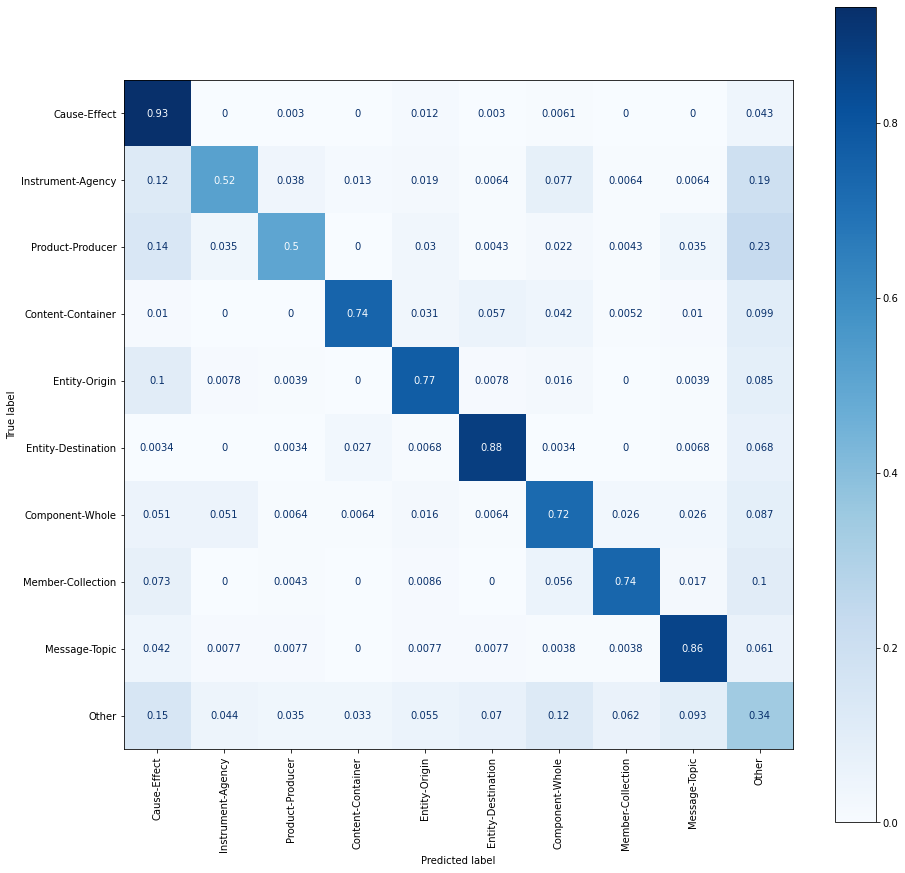

In [ ]:
data_loader_test = get_data_loader(Relation_Extraction_dataset, vocab, collate_fn, 
                                   batch_size=64, sentences=test_sentences, labels=test_labels)

evaluate_test(data_loader_test, baseline_model, model_file = "baseline_blstm", plot_confusion_matrix=True)

## BLSTM With Contextual

Based on the baseline model, take maxpool over contextual hidden vectors around entity and add them to the MLP.

https://www.aclweb.org/anthology/Y15-1009.pdf

In [ ]:
 class Baseline_BLSTM_With_NB(Baseline_BLSTM):
    def __init__(self, vocab, emb_dim=100, hidden_dim=100, num_layers=1, tgts_dim=10, dropout_emb=0.3, dropout_lstm=0.3, dropout_linear=0.5):
        super().__init__(vocab,  emb_dim, hidden_dim, num_layers, tgts_dim, dropout_emb, dropout_lstm, dropout_linear)


        # archeture components
        self.embed = nn.Embedding(self.num_words, emb_dim)
        #self.init_glove(GloVe)
        self.blstm = nn.LSTM(emb_dim, hidden_dim, num_layers, dropout=dropout_lstm, bidirectional=True) 
        self.linear = nn.Linear(8*hidden_dim, tgts_dim) # 8 = 2 * 4, bidirectional and concate, 

        self.loss_fn = nn.CrossEntropyLoss(reduction='mean')


    def compute_loss(self, batch_data):
        '''
        Args:
            batch_data: {
                sentences: int tensor [padded_length, batch_size]
                masks: {'e1': [padded_length, batch_size], 'e1_nb': ..., 'e2': ..., 'e2_nb': ...} 
                tgts: int tensor [batch_size]
            }
        Returns:
            loss: torch scaler
        '''
        logits = self.forward(batch_data) # [batch, tgts_dim]
        return self.loss_fn(logits, batch_data['labels']), logits

    def init_glove(self, GloVe):
      #TODO: initialize word embeddings using GloVe (you can skip this part in your first version, if you want, see instructions below).
      words = GloVe.keys()

      for word in words:
          if word in vocab.word_to_id:
            self.embed.weight.data[vocab.word_to_id[word]] = torch.as_tensor(GloVe[word]) 
    # forward with masks sequence
    def forward(self, batch_data):
        '''
        Args:
            batch_data: {
                'sentences': int tensor [padded_length, batch_size]
                'masks': {'e1': [padded_length, batch_size], 'e1_nb': ..., 'e2': ..., 'e2_nb': ...} 
                ...
            }
        Returns:
            logits: tensor [batch, tgts_dim]
        '''
        
        seqs = batch_data['sentences']
        tag_masks=batch_data['masks']
        # Compute a tensor containing the length of each source sequence.
        seq_lengths = torch.sum(seqs != pad_id, axis=0).cpu()

        # batch_size = seqs.size(1)
        # batch_indices = torch.tensor([i for i in range(batch_size)])

        embeddings = self.embed_fn(seqs)
        unpacked = self.blstm_fn(embeddings, seq_lengths)  

        e1_hiddens, e2_hiddens = self.get_entities_feat(unpacked, tag_masks)

        unpacked = unpacked.permute(2, 0, 1) # [2*hidden_dim, padded_length, batch]
        e1_nb_hiddens = torch.max(unpacked * tag_masks['e1_nb'], dim = 1)[0].permute(1, 0) # [batch, 2*hidden_dim]
        e2_nb_hiddens = torch.max(unpacked * tag_masks['e2_nb'], dim = 1)[0].permute(1, 0) # [batch, 2*hidden_dim]

        linear_in = torch.cat([e1_hiddens, e1_nb_hiddens, e2_hiddens, e2_nb_hiddens], dim=1)
        linear_in = self.linear_dropout(linear_in)

        return self.linear(linear_in) # [batch, tgts_dim]


    



In [ ]:
baseline_nb_model = Baseline_BLSTM_With_NB(vocab, emb_dim=300, hidden_dim=100, num_layers=1, tgts_dim=10).to(device)

example_data = next(iter(data_loader))
example_out = baseline_nb_model(example_data)
print(example_out.shape)

torch.Size([32, 10])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Train model

In [ ]:
# hyper parameters
learning_rate = 0.0005
num_epochs = 15
model_file = 'baseline_model_with_nb'
#optimizer = torch.optim.Adam(baseline_nb_model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adadelta(baseline_nb_model.parameters(), lr = 1, weight_decay=1E-5)
train(baseline_nb_model, data_loader, num_epochs, model_file, optimizer)
#files.download('baseline_model_with_nb.pt')


total loss:  416.5126243829727
accuracy:  0.41325
f1 score:  0.41498156476230097



total loss:  319.80754512548447
accuracy:  0.5565
f1 score:  0.5713221680924903



total loss:  273.0322699546814
accuracy:  0.621875
f1 score:  0.6370759501198849



total loss:  241.9049453139305
accuracy:  0.66675
f1 score:  0.6810837558725633



total loss:  213.58885172009468
accuracy:  0.708375
f1 score:  0.7242419766012962



total loss:  191.7493477165699
accuracy:  0.728125
f1 score:  0.7447258678359931



total loss:  171.55157689750195
accuracy:  0.754125
f1 score:  0.7678434171250675



total loss:  155.50585451722145
accuracy:  0.783
f1 score:  0.7967267325793508



total loss:  139.63657023012638
accuracy:  0.802
f1 score:  0.8145194961059049



total loss:  133.50697779655457
accuracy:  0.82375
f1 score:  0.8353084993316306



total loss:  117.9721165895462
accuracy:  0.834375
f1 score:  0.8472355855941404



total loss:  107.42630376666784
accuracy:  0.84525
f1 score:  0.8559094372607652



total loss:  103.10598319023848
accuracy:  0.861375
f1 score:  0.8704800745249651



total loss:  93.54172112047672
accuracy:  0.864625
f1 score:  0.8739844937645026



total loss:  89.65246059000492
accuracy:  0.8735
f1 score:  0.8825384577642511



Evaluate the baseline mode with contextual 

accuracy:  0.6864188443135811
f1 score:  0.6956381752718459


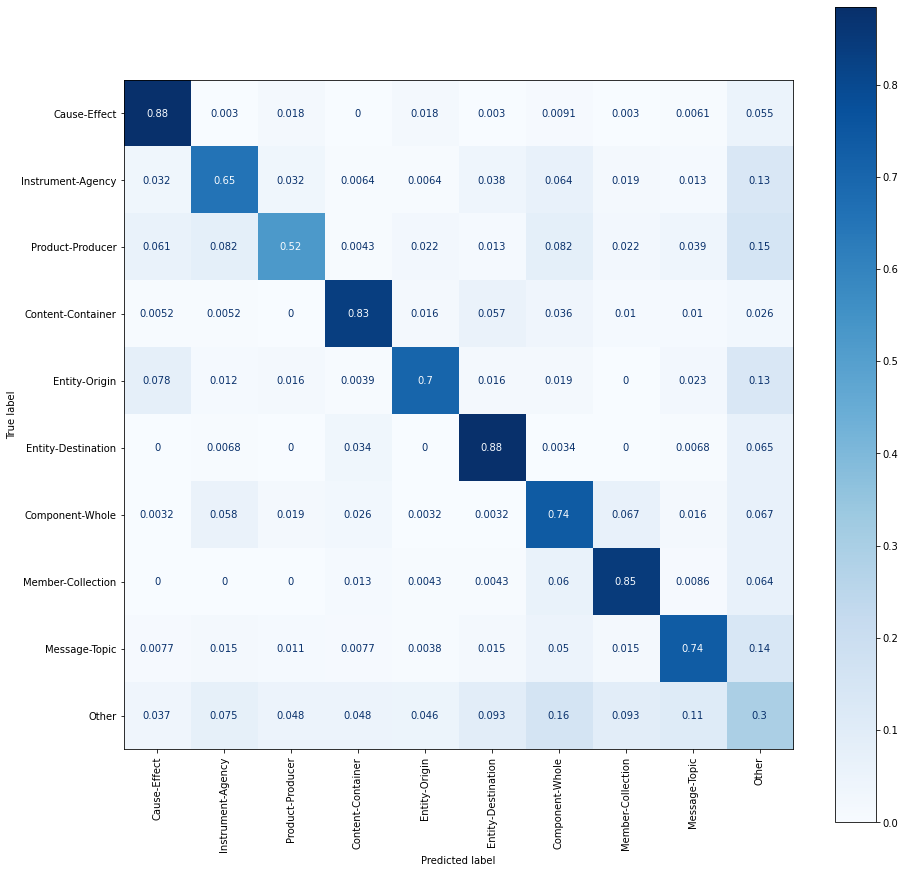

In [ ]:
evaluate_test(data_loader_test, baseline_nb_model,model_file = "blstm_context", plot_confusion_matrix=True)

## BLSTM with Attention
 https://www.aclweb.org/anthology/P16-2034.pdf 

In [ ]:
class Attn_BLSTM(Baseline_BLSTM):
    def __init__(self, vocab, emb_dim=100, hidden_dim=100, num_layers=1, tgts_dim=10, dropout_emb=0.3, dropout_lstm=0.3, dropout_linear=0.5):
        super().__init__(vocab, emb_dim, hidden_dim, num_layers, tgts_dim, dropout_emb, dropout_lstm, dropout_linear)

        # wt = torch.empty((1, self.hidden_dim * 2))
        # torch.nn.init.xavier_uniform_(wt)
        self.wt = torch.nn.Parameter(torch.ones(1, self.hidden_dim*2), requires_grad=True)

        self.linear = nn.Linear(2*hidden_dim, tgts_dim)

    def compute_loss(self, batch_data):
        logits = self.forward(batch_data) # [batch, tgts_dim]
        return self.loss_fn(logits, batch_data['labels']), logits

    def forward(self, batch_data):
        '''
        Args:
            batch_data: {
                'sentences': int tensor [padded_length, batch_size],
                'labels': int tensor [batch_size],
                'seq_lengths': ,
            }
        Returns:
            logits: tensor [batch, tgts_dim]
        '''
        seqs = batch_data['sentences']
        seq_lengths = batch_data['seq_lengths']
        # seq_lengths = torch.sum(seqs != pad_id, axis=0).cpu()

        embeddings = self.embed_fn(seqs)
        unpacked = self.blstm_fn(embeddings, seq_lengths)
    
        M = torch.tanh(unpacked).permute(1, 2, 0) # [batch, 2*hidden_dim, padded_length]    

        wt_M = torch.matmul(self.wt, M).squeeze() # [batch, length]
        padding_mask = (seqs == 0).permute(1, 0) # [batch, length]
        wt_M[padding_mask] = float('-inf')

        alpha = F.softmax(wt_M, dim=1).unsqueeze(2) # [batch, length, 1]

        r = torch.matmul(unpacked.permute(1,2,0), alpha).squeeze()

        r = self.linear_dropout(r)

        return self.linear(torch.tanh(r))

    # def blstm_fn(self, embeddings, seq_lengths):
    #     packed = pack_padded_sequence(embeddings, seq_lengths)
    #     rnn_out, _ = self.blstm(packed)
    #     unpacked, _ = pad_packed_sequence(rnn_out) # unpacked: [padded_length, batch, 2*hidden_dim] 
    #     seqLen, batch_O, _= unpacked.shape
    #     fb = unpacked.view(seqLen, batch_O, 2, self.hidden_dim)
    #     output = fb[:,:,0,:] + fb[:,:,1,:]
    #     #print(output.shape)
    #     #unpacked.to(device)
    #     return output

## Data processing for Attention Model
The data loader is specific to attention model, where we treat \<e1>, \</e1>, \<e2>, \</e2> as individual word.  

In [ ]:
class Attention_dataset(Dataset):

    def __init__(self, sentences, relations, vocab, device):
        """
        Args:
          sentences: a list of sentences, including tags for relations
              (e.g. "The ... <e1>inflammation</e1> in ... pylori <e2>infection</e2> results ... stomach.")
          relations: a list of strings describing the relations 
              (e.g. "Cause-Effect(e2,e1)")
          vocab: Vocabulary object that contains the mapping of words to indices
          device: cpu or cuda
        """
        self.sentences = sentences
        self.relations = relations
        self.vocab = vocab
        self.device = device

        def encode(sentence, relation):
            sentence_ids = self.vocab.get_ids_from_sentence(sentence)
            target_class = parse_relation(relation)
            return (sentence_ids, target_class)

        self.tokenized_pairs = [encode(src, tgt) for src, tgt in zip(self.sentences, self.relations)]
        
    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tokenized_pairs[idx]



def collate_fn_attn(data):
    """Creates mini-batch tensors
    Args:
        data: list of tuples (sentence_ids, entity_tag_indices, target_index, tags_masks)
            - sentence_ids: list of word ids; variable length
            - target_index: int representing target relation
    Returns: dict { 
                  "sentences": torch 2D tensor of shape [padded_length, batch_size] for the encoded sentence input
                  "labels": torch 1D tensor of shape [batch_size] for the relation class
              }  
    
    For example,

    sentence:<s> I think <e1> Tom </e1> comes from <e2> San Jose </e2>  .  </s>
    idx      0   1   2    3    4    5     6    7     8   9   10    11   12  13
 
    """
    data.sort(key = lambda x: len(x[0]), reverse=True)

    seq_lengths = torch.tensor([len(x[0]) for x in data], requires_grad=False)

    sentence_ids = [torch.LongTensor(e[0]) for e in data]
    sentence_tensor = nn.utils.rnn.pad_sequence(sentence_ids).to(device)
    labels_tensor = torch.tensor([e[1] for e in data]).to(device)

    return { "sentences": sentence_tensor, "labels": labels_tensor, 'seq_lengths': seq_lengths}



In [ ]:
# vocab specific for the attention model
vocab_attn = build_vocab(keep_entity_tag=True)
data_loader = get_data_loader(Attention_dataset, vocab_attn, collate_fn_attn, batch_size=32)

Total words in the vocabulary = 20559


Training attention model

In [ ]:
attn_model = Attn_BLSTM(vocab_attn, emb_dim=300, hidden_dim=100, num_layers=1, tgts_dim=10)
attn_model.to(device)

example_data = next(iter(data_loader))

example_out = attn_model(example_data)
print(example_out.shape)

print(attn_model.parameters)

torch.Size([32, 10])
<bound method Module.parameters of Attn_BLSTM(
  (embed): Embedding(20559, 300)
  (dropout_embed): Dropout(p=0.3, inplace=False)
  (blstm): LSTM(300, 100, dropout=0.3, bidirectional=True)
  (linear): Linear(in_features=200, out_features=10, bias=True)
  (linear_dropout): Dropout(p=0.5, inplace=False)
  (loss_fn): CrossEntropyLoss()
)>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
# hyper parameters
num_epochs = 12
model_file = 'attn_model'
optimizer = torch.optim.Adadelta(attn_model.parameters(), lr = 1, weight_decay=1E-5)

train(attn_model, data_loader, num_epochs, model_file, optimizer)
#files.download('baseline_model.pt')



total loss:  402.36756002902985
accuracy:  0.444125
f1 score:  0.44902950104982864



total loss:  283.0647964477539
accuracy:  0.59725
f1 score:  0.6109445236299151



total loss:  240.39143350720406
accuracy:  0.6605
f1 score:  0.6767394504618249



total loss:  213.22450411319733
accuracy:  0.700625
f1 score:  0.7135869831520697



total loss:  188.7517322897911
accuracy:  0.735875
f1 score:  0.7495982752774479



total loss:  166.85608944296837
accuracy:  0.765375
f1 score:  0.7784985483256764



total loss:  149.28786063194275
accuracy:  0.789
f1 score:  0.8018646731988952



total loss:  132.23651400208473
accuracy:  0.81775
f1 score:  0.8300219876113945



total loss:  117.60473461449146
accuracy:  0.834125
f1 score:  0.8452256061716097



total loss:  106.1570588722825
accuracy:  0.853875
f1 score:  0.8648874489334947



total loss:  89.17451628297567
accuracy:  0.872125
f1 score:  0.8806845751655862



total loss:  80.70289262384176
accuracy:  0.889125
f1 score:  0.8967366362788338



Evaluate the attention model

accuracy:  0.7258005152741995
f1 score:  0.7402819824093924


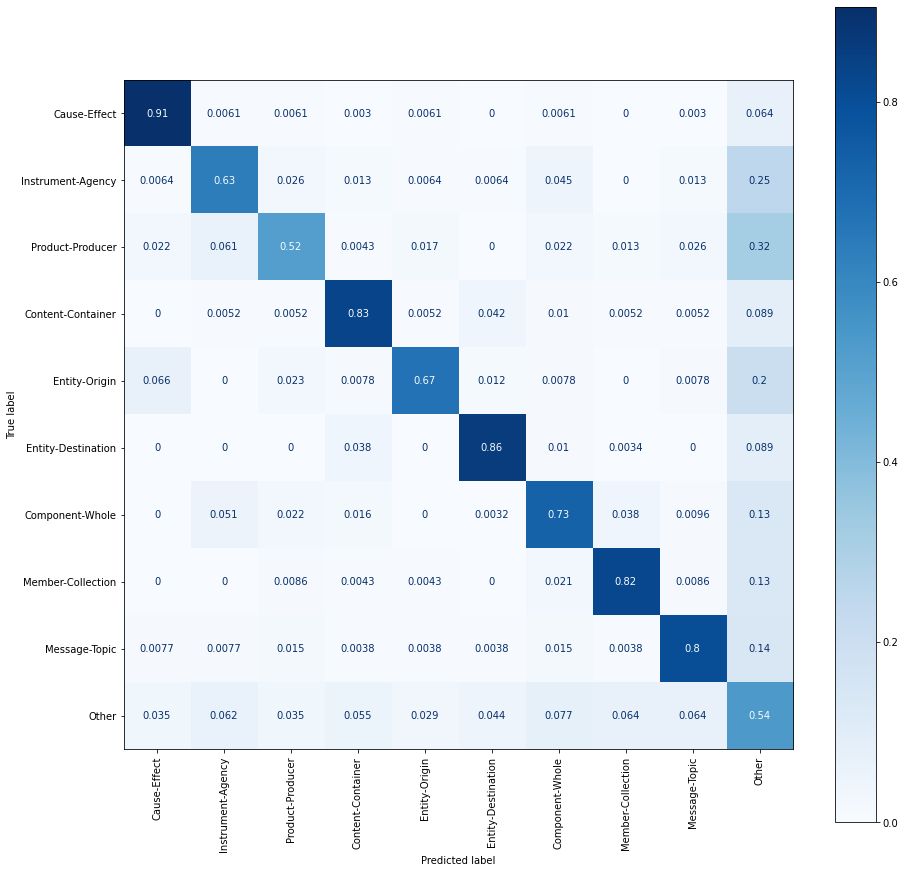

In [ ]:
data_loader_test = get_data_loader(Attention_dataset, vocab, collate_fn_attn, batch_size=10, sentences=test_sentences, labels=test_labels)

evaluate_test(data_loader_test, attn_model, model_file = "blstm_attn")

## BERT

Load model and tokenizer from Hugging Face

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 8.4MB/s 
     |████████████████████████████████| 3.3MB 50.2MB/s 
     |████████████████████████████████| 901kB 50.4MB/s 


In [ ]:
from transformers import BertTokenizer, AdamW, BertForSequenceClassification, BertModel

# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)

# optimizer = AdamW(model.parameters(), lr=2e-5)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Data processing for BERT

In [ ]:
# credit: https://github.com/wang-h/bert-relation-classification/blob/master/utils.py 
def clean_str(text):
    text = text.lower()
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=<>]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"that's", "that is ", text)
    text = re.sub(r"there's", "there is ", text)
    text = re.sub(r"it's", "it is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

def normalize_sentence_BERT(s):
    s = re.sub("<e1>", "# ", s)
    s = re.sub("<e2>", "$ ", s)
    s = re.sub("< e1>", " #", s)
    s = re.sub("< e2>", " $", s)
    return s

In [ ]:
def get_bert_dataloader(data_set_class, sentences, labels, batch_size, collate_fn):
    dataset = data_set_class(sentences, labels)
    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


Make it compatable with the train loop and evaluation function

In [ ]:
# clear up RAM
obj = None
import gc
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

### Frozen BERT

In [ ]:
f_model = BertModel.from_pretrained('bert-base-uncased')
# f_model.to(device)

In [ ]:
class BERT_Frozen_dataset(Dataset):

    def __init__(self, sentences, relations):
        """
        Args:
          sentences: a list of sentences, including tags for relations
              (e.g. "The ... <e1>inflammation</e1> in ... pylori <e2>infection</e2> results ... stomach.")
          relations: a list of strings describing the relations 
              (e.g. "Cause-Effect(e2,e1)")
          vocab: Vocabulary object that contains the mapping of words to indices
        """
        self.sentences = sentences
        self.relations = relations
 
        f_model.eval()

        def encode(sentence, relation):
            sentence = normalize_sentence_BERT(clean_str(sentence))   
            # 1001, 1002
            ids =  tokenizer(sentence)

            e1_s_idx, e1_e_idx, e2_s_idx, e2_e_idx = None, None, None, None
            e1_first = True
            for idx, id in enumerate(ids['input_ids']):
                if id == 1001 and e1_s_idx == None:
                    e1_s_idx = idx 
                elif id == 1001:
                    e1_e_idx = idx
                elif id == 1002 and e2_s_idx == None:
                    e2_s_idx = idx 
                    if e1_s_idx == None:
                        e1_first = False
                elif id == 1002:
                    e2_e_idx = idx 
            
        #   0 1 2 # 3 # 4 $ 5 6 $  7  8     
        #   0 1 2 3 4 5 6 7 8 9 10 11 12 
            if e1_first:
                e1_e_idx -= 1
                e2_s_idx -= 2
                e2_e_idx -= 3
            else:
                e2_e_idx -= 1
                e1_s_idx -= 2
                e1_e_idx -= 3
            
            sentence = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", sentence)

            bert_in = tokenizer(sentence, return_tensors='pt')#.to(device)

            with torch.no_grad():
                bert_out = f_model(**bert_in) 

            cls_feature = bert_out.pooler_output 
            e1_feature = torch.mean(bert_out.last_hidden_state[:, e1_s_idx:e1_e_idx, :], dim=1)
            e2_feature = torch.mean(bert_out.last_hidden_state[:, e2_s_idx:e2_e_idx, :], dim=1)
            
            features =  torch.cat([cls_feature, e1_feature, e2_feature], dim=1)

            target_class = parse_relation(relation)
            
            return (features, target_class)

        self.tokenized_pairs = [encode(src, tgt) for src, tgt in zip(self.sentences, self.relations)]
        
    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tokenized_pairs[idx]


def collate_fn_bert(data):
    """Creates mini-batch tensors
    Args:
        data: list of tuples (sentence_ids, target_index)
            - sentence_ids: list of word ids; variable length
            - target_index: int representing target relation 
    """
    features = torch.cat([e[0] for e in data], dim=0)
    
    labels = torch.tensor([e[1] for e in data])
    
    return { 
        "features": features.to(device),  
        'labels': labels.to(device)
        }

In [ ]:
bert_frozen_dataloader_train = get_bert_dataloader(BERT_Frozen_dataset, train_sentences, train_labels, batch_size=10, collate_fn=collate_fn_bert)
bert_frozen_dataloader_test = get_bert_dataloader(BERT_Frozen_dataset, test_sentences, test_labels, batch_size=10, collate_fn=collate_fn_bert)

In [ ]:
example_out = next(iter(bert_frozen_dataloader_train))
print(example_out['features'])

tensor([[-0.7841, -0.2233, -0.4263,  ..., -0.6511,  0.1683, -0.4193],
        [-0.8601, -0.4597, -0.7549,  ..., -0.0956, -0.0953,  0.4829],
        [-0.7455, -0.2144,  0.1201,  ..., -0.0540, -0.0932, -0.4096],
        ...,
        [-0.6560, -0.0815, -0.2786,  ...,  0.4567,  0.1516,  0.0026],
        [-0.5870,  0.2956,  0.6434,  ..., -0.6021,  0.0393,  0.1189],
        [-0.7363,  0.0051, -0.0218,  ...,  0.2470, -0.0810,  0.1747]],
       device='cuda:0')


In [ ]:
class BERT_SEC(nn.Module):
    def __init__(self, bert_model, dropout_linear=0.5):
        super().__init__()

        # archeture components
        self.bert_model = bert_model
        self.linear_dropout = nn.Dropout(p=dropout_linear)
        self.linear_hidden = nn.Linear(768*3, 256)
        self.linear = nn.Linear(256, 10) # 8 = 2 * 4, bidirectional and concate, 
        self.loss_fn = nn.CrossEntropyLoss(reduction='mean')


    def compute_loss(self, batch_data):
        '''
        Args:
            batch_data: {
                sentences: int tensor [padded_length, batch_size]
                masks: {'e1': [padded_length, batch_size], 'e1_nb': ..., 'e2': ..., 'e2_nb': ...} 
                tgts: int tensor [batch_size]
            }
        Returns:
            loss: torch scaler
        '''
        logits = self.forward(batch_data) # [batch, tgts_dim]
        return self.loss_fn(logits, batch_data['labels'])


    # forward with masks sequence
    def forward(self, batch_data):
        '''
        Args:
            batch_data: {
                'features': int tensor [padded_length, batch_size]
                ...
            }
        Returns:
            logits: tensor [batch, tgts_dim]
        '''
        features = batch_data['features']
        out = self.linear_hidden(features)
        out = self.linear_dropout(out)
        return self.linear(out) # [batch, tgts_dim]


In [ ]:
bert_sec_model = BERT_SEC(f_model).to(device)

In [ ]:
optimizer = torch.optim.Adam(bert_sec_model.parameters(), lr = 5E-5)
# optimizer = torch.optim.Adadelta(bert_sec_model.parameters(), lr = 1, weight_decay=1E-5)
num_epochs = 20
train(bert_sec_model, bert_frozen_dataloader_train, num_epochs, '', optimizer)


total loss:  1353.8493900299072
accuracy:  0.460375
f1 score:  0.4542163178944941



total loss:  912.2427031099796
accuracy:  0.6445
f1 score:  0.6543530728511743



total loss:  747.0622346103191
accuracy:  0.697125
f1 score:  0.7088876707950361



total loss:  665.5654885023832
accuracy:  0.723875
f1 score:  0.7347393316046933



total loss:  601.5989254117012
accuracy:  0.74675
f1 score:  0.7587549939437954



total loss:  558.4390946403146
accuracy:  0.76775
f1 score:  0.7788017673862082



total loss:  521.6318279653788
accuracy:  0.783375
f1 score:  0.7958611310225624



total loss:  488.0733395963907
accuracy:  0.793625
f1 score:  0.8052014549158135



total loss:  467.31491363048553
accuracy:  0.807375
f1 score:  0.8181701656416729



total loss:  440.74850771576166
accuracy:  0.816
f1 score:  0.8271686981920698



total loss:  420.8492616713047
accuracy:  0.8245
f1 score:  0.8358793462273534



total loss:  405.8343763872981
accuracy:  0.830625
f1 score:  0.8415067984595176



total loss:  386.2305924743414
accuracy:  0.840125
f1 score:  0.8512120419431819



total loss:  376.6032547727227
accuracy:  0.841375
f1 score:  0.8532058162965852



total loss:  358.57364709302783
accuracy:  0.851125
f1 score:  0.8612885092683742



total loss:  343.9744661822915
accuracy:  0.85425
f1 score:  0.8637990537777178



total loss:  335.05389465391636
accuracy:  0.861625
f1 score:  0.8726908231442841



total loss:  320.98881040513515
accuracy:  0.869625
f1 score:  0.8795311958701711



total loss:  309.92100313305855
accuracy:  0.871875
f1 score:  0.881985711035688



total loss:  300.72048184648156
accuracy:  0.87775
f1 score:  0.8875651770904746



accuracy:  0.7666543982333456
f1 score:  0.7781926747855568


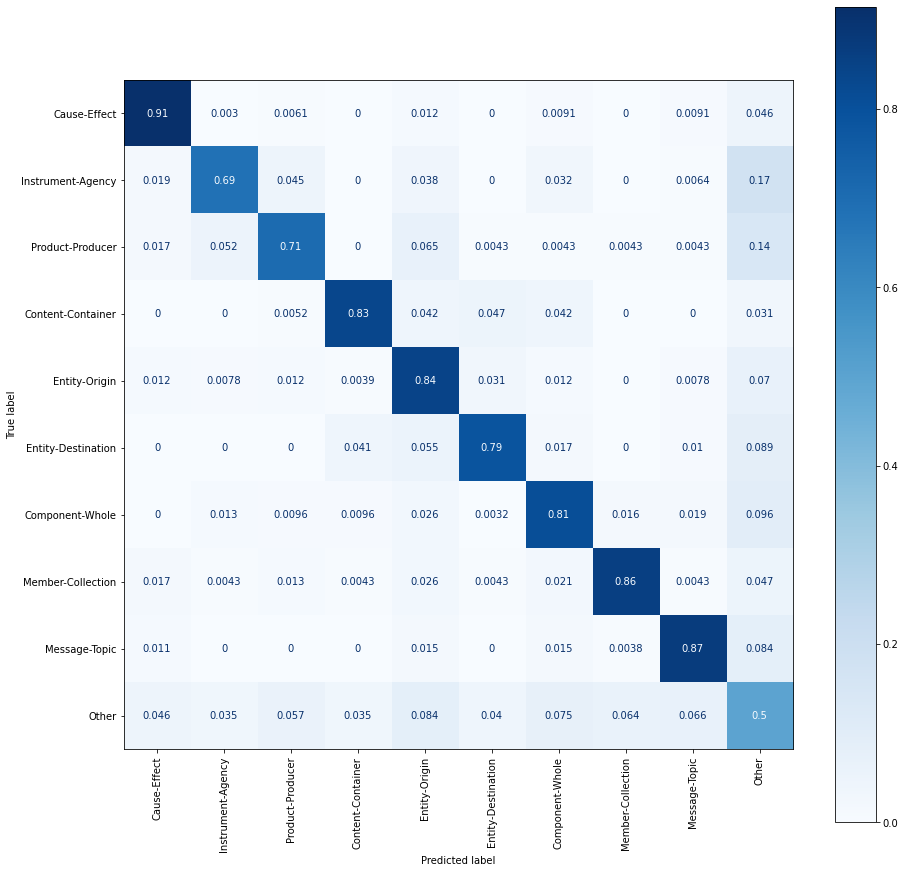

In [ ]:
evaluate_test(bert_frozen_dataloader_test, bert_sec_model, model_file = "", plot_confusion_matrix=True)

## BERT Fine Tunning

In [ ]:
f_model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
class BERT_FT_dataset(Dataset):

    def __init__(self, sentences, relations):
        """
        Args:
          sentences: a list of sentences, including tags for relations
              (e.g. "The ... <e1>inflammation</e1> in ... pylori <e2>infection</e2> results ... stomach.")
          relations: a list of strings describing the relations 
              (e.g. "Cause-Effect(e2,e1)")
          vocab: Vocabulary object that contains the mapping of words to indices
        """
        self.sentences = sentences
        self.relations = relations
 
        self.include_tag_token = True

        f_model.eval()

        def encode(sentence, relation):
            sentence = normalize_sentence_BERT(clean_str(sentence))   
            # 1001, 1002
            ids =  tokenizer(sentence)

            e1_s_idx, e1_e_idx, e2_s_idx, e2_e_idx = None, None, None, None
            e1_first = True
            for idx, id in enumerate(ids['input_ids']):
                if id == 1001 and e1_s_idx == None:
                    e1_s_idx = idx 
                elif id == 1001:
                    e1_e_idx = idx
                elif id == 1002 and e2_s_idx == None:
                    e2_s_idx = idx 
                    if e1_s_idx == None:
                        e1_first = False
                elif id == 1002:
                    e2_e_idx = idx 
            
            if self.include_tag_token:
                e1_s_idx += 1
                e2_s_idx += 1
            else:
            #   0 1 2 # 3 # 4 $ 5 6 $  7  8     
            #   0 1 2 3 4 5 6 7 8 9 10 11 12 
                if e1_first:
                    e1_e_idx -= 1
                    e2_s_idx -= 2
                    e2_e_idx -= 3
                else:
                    e2_e_idx -= 1
                    e1_s_idx -= 2
                    e1_e_idx -= 3
                
                sentence = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", sentence)

            bert_in = tokenizer(sentence, return_tensors='pt', padding=True)#.to(device)
 
            target_class = parse_relation(relation)
            
            return (bert_in, target_class, {'e1_s': e1_s_idx, 'e1_e': e1_e_idx, 'e2_s': e2_s_idx, 'e2_e': e2_e_idx})

        self.tokenized_pairs = [encode(src, tgt) for src, tgt in zip(self.sentences, self.relations)]
        
    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tokenized_pairs[idx]


def collate_fn_ft_bert(data):
    """Creates mini-batch tensors
    Args:
        data: list of tuples (sentence_ids, target_index)
            - sentence_ids: list of word ids; variable length
            - target_index: int representing target relation 
    """
    # features = torch.cat([e[0] for e in data], dim=0)
    bert_in = [e[0].to(device) for e in data]
    labels = torch.tensor([e[1] for e in data])
    tags = [e[2] for e in data]

    return { 
        # "features": features.to(device),  
        'bert_in': bert_in,
        'labels': labels.to(device),
        'tags': tags,
        }

In [ ]:
bert_ft_dataloader_train = get_bert_dataloader(BERT_FT_dataset, train_sentences, train_labels, batch_size=10, collate_fn=collate_fn_ft_bert)
bert_ft_dataloader_test = get_bert_dataloader(BERT_FT_dataset, test_sentences, test_labels, batch_size=10, collate_fn=collate_fn_ft_bert)

### BERT Fine Tuning Model

In [ ]:
class BERT_FT(nn.Module):
    def __init__(self, bert_model, dropout_linear=0.5, freeze=True):
        super().__init__()

        # archeture components
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.linear_dropout = nn.Dropout(p=dropout_linear)
        self.linear = nn.Linear(768*3, 10) 
        self.loss_fn = nn.CrossEntropyLoss(reduction='mean')

        if freeze:
            self.freeze_encoder()
        
    
    def freeze_encoder(self):
        # reset requires_grad to all True
        for name, param in list(f_model.named_parameters()):  
            param.requires_grad = True

        # freeze the parts of layers (-79)
        for name, param in list(self.bert_model.named_parameters())[:-6]: 
            # print('I will be frozen: {}'.format(name)) 
            param.requires_grad = False
        


    def compute_loss(self, batch_data):
        '''
        Args:
            batch_data: {
                sentences: int tensor [padded_length, batch_size]
                masks: {'e1': [padded_length, batch_size], 'e1_nb': ..., 'e2': ..., 'e2_nb': ...} 
                tgts: int tensor [batch_size]
            }
        Returns:
            loss: torch scaler
        '''
        logits = self.forward(batch_data) # [batch, tgts_dim]
        return self.loss_fn(logits, batch_data['labels']), logits


    # forward with masks sequence
    def forward(self, batch_data):
        '''
        Args:
            batch_data: {
                'bert_in': [ bert_input ]
                'tags': dict{e1_s, e1_e, e2_s, e2_e}
                ...
            }
        Returns:
            logits: tensor [batch, tgts_dim]
        '''

        self.bert_model.eval()

        features = []
        for i in range(len(batch_data['tags'])):
            bert_in  = batch_data['bert_in'][i]
            e1_s_idx, e1_e_idx = batch_data['tags'][i]['e1_s'], batch_data['tags'][i]['e1_e']
            e2_s_idx, e2_e_idx = batch_data['tags'][i]['e2_s'], batch_data['tags'][i]['e2_e']

            bert_out =  self.bert_model(**bert_in) 

            cls_feature = bert_out.pooler_output 
            e1_feature = torch.mean(bert_out.last_hidden_state[:, e1_s_idx:e1_e_idx, :], dim=1)
            e2_feature = torch.mean(bert_out.last_hidden_state[:, e2_s_idx:e2_e_idx, :], dim=1)
            
            features.append(torch.cat([cls_feature, e1_feature, e2_feature], dim=1))

        features = torch.cat(features, dim=0)
        linear_in = self.linear_dropout(features)
        return self.linear(linear_in) # [batch, tgts_dim]


In [ ]:
bert_ft_model = BERT_FT(f_model, dropout_linear=0.5, freeze=False).to(device)

In [ ]:
for name, param in list(bert_ft_model.bert_model.named_parameters()): 
    # print('I will be frozen: {}'.format(name)) 
    param.requires_grad = True
print('Trainable parameters count: ', sum(p.numel() for p in bert_ft_model.parameters() if p.requires_grad))

Trainable parameters count:  109505290


### Train

In [ ]:
optimizer = torch.optim.Adam(bert_ft_model.parameters(), lr = 1E-5)
# optimizer = torch.optim.Adadelta(bert_ft_model.parameters(), lr = 1, weight_decay=1E-5)
num_epochs = 5
train(bert_ft_model, bert_ft_dataloader_train, num_epochs, '', optimizer)


total loss:  26.45241783198435
accuracy:  0.99075
f1 score:  0.99172413489765



accuracy:  0.8306956201693044
f1 score:  0.8413512488177041


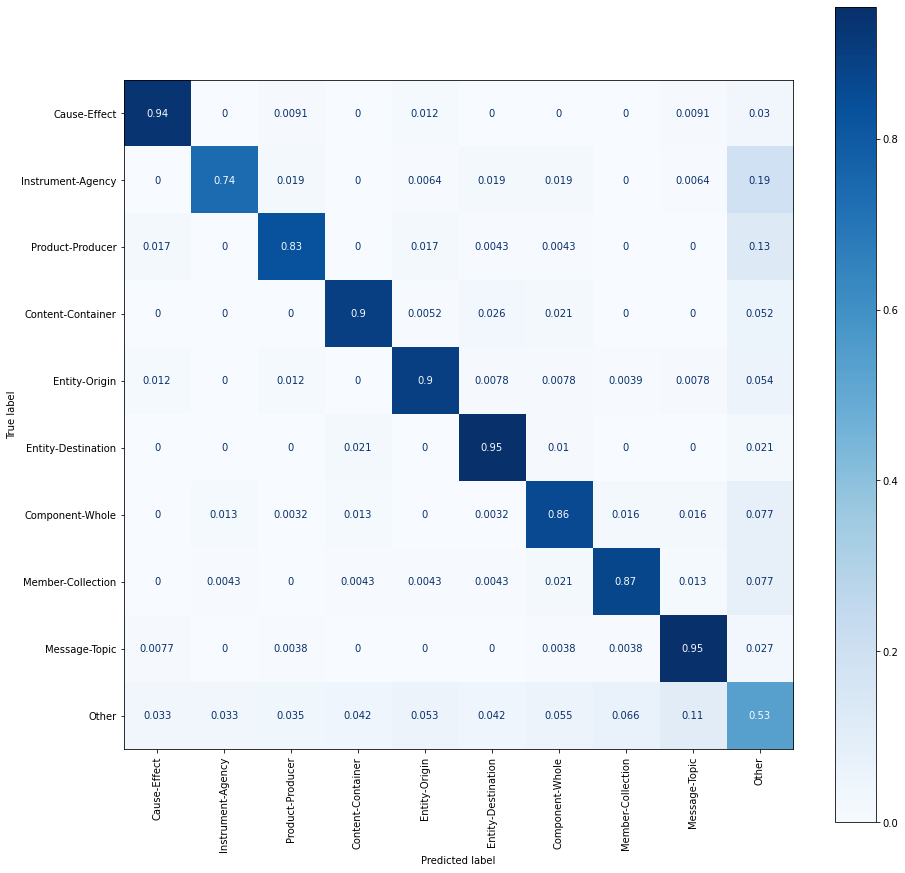

In [ ]:
evaluate_test(bert_ft_dataloader_test, bert_ft_model, model_file = "", plot_confusion_matrix=True)

# Evaluation with Pretrained Models and OpenIE Methods